In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Aprendizaje de Máquina 1

## Trabajo Práctico Final

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Leonardo Centurión    | centurionm.leo@gmail.com  | a1803   |
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Juan José Cardinali   | juanchijc@gmail.com       | a1809   |
| Rodrigo Meza          | rodrigolx31@gmail.com     | a1815   |

### 1. INTRODUCCIÓN

Este trabajo comprende el análisis del dataset **Rain in Australia** el cual comprende cerca de 10 años de observaciones de variables climáticas en diferentes localizaciones de Australia. Incluye datos como la cantidad de lluvia diaria, la dirección y la velocidad del viento, la temperatura, la humedad, la presión atmosférica, entre otras. 

La variable objetivo es `RainTomorrow` y, básicamente, responde en forma binaria si va a llover o no el día siguiente.

El dataset ha sido descargado de [Kaggle](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package).


### 2. LIBRERÍAS

In [3]:
# Custom library For dataset analysis
from pipeline import HierarchicalImputer
from pipeline import CoordinateTransformer2
from pipeline import WindDirectionTransformer
from pipeline import ExtendedWindDirectionTransformer
from pipeline import DropColumnsTransformer
from pipeline import RainTodayTransformer
from pipeline import ExpandDateTransformer
from pipeline import CountNullsTransformer
from pipeline import eval_pipeline
from pipeline import sample_array
from pipeline import report_results

from persistence import load_or_fit

# For data manipulation
import pandas as pd
import numpy as np
import pandas as pd

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For GEO coords
from geopy.geocoders import Nominatim

# For string manipulation
import re

# For ML models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import joblib

### 3. ANÁLISIS EXPLORATORIO DE DATOS

#### 3.1 Preliminar

In [4]:
# Lectura de datos
rain_df = pd.read_csv('../data/weatherAUS.csv')

In [5]:
# Veamos las primeras instancias
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
# Y los nombres de las columnas
rain_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [7]:
# Veamos el número de instancias (filas) y el de features+target (columnas)
rain_df.shape

(145460, 23)

In [8]:
ninstances = rain_df.shape[0]         # Guardamos el número de instancias
nfeatures = rain_df.shape[1]-1        # Guardamos el número de atributos (Descuento uno correspondiente al target)

In [9]:
# Veamos entre que fechas se llevó a cabo la toma de datos
print('La fecha de inicio de toma de datos es:', rain_df['Date'].min())
print('La fecha de final de toma de datos es:', rain_df['Date'].max())

La fecha de inicio de toma de datos es: 2007-11-01
La fecha de final de toma de datos es: 2017-06-25


**OBSERVACIONES:**

- Se tiene 145460 instancias.

- El dataset tiene unas 23 columnas, de las cuales 22 corresponden a *features* 
mientras que la última al *target* que define si llueve o no al otro día, dadas las condiciones del día actual.

- La primer columna corresponde a la fecha en la cual se tomaron los datos.

- Los datos van desde el 1º de Noviembre de 2007 hasta el 25 de Junio de 2017.

#### 3.2 Definición de columnas
De acuerdo a lo informado en Kaggle:

| **Nombre de Columna** | **Descripción** | **Unidad/Formato** |
| --------------- | -------------- | --------- |
| `Date` | Fecha de la observación meteorológica. | YYYY-MM-DD |
| `Location` | Estación meteorológica donde se registró la observación. | -- |
| `MinTemp` | Temperatura mínima registrada durante el día. | ºC |
| `MaxTemp` | Temperatura máxima registrada durante el día. | ºC |
| `Rainfall` | Cantidad de precipitación registrada durante el día. Si no hubo lluvia, este valor será cero. | Milímetros |
| `Evaporation` | Cantidad de evaporación (en milímetros) registrada durante el día. Mide la pérdida de agua de la superficie debido a la evaporación. | Milímetros |
| `Sunshine` | Horas de sol registradas durante el día. | Horas |
| `WindGustDir` | Dirección de la ráfaga de viento más fuerte registrada durante el día. | 16 Puntos de compas |
| `WindGustSpeed` | elocidad (en kilómetros por hora) de la ráfaga de viento más fuerte registrada durante el día. | Km/h |
| `WindDir9am` | Dirección del viento a las 9 AM del día. | 16 Puntos de compas |
| `WindDir3pm` | Dirección del viento a las 3 PM del día. | 16 Puntos de compas |
| `WindSpeed9am` | Velocidad del viento a las 9 AM del día.  | Km/h |
| `WindSpeed3pm` | Velocidad del viento a las 9 PM del día.  | Km/h |
| `Humidity9am` | Humedad relativa a las 9 AM del día. | Porcentaje |
| `Humidity3pm` | Humedad relativa a las 3 PM del día. | Porcentaje |
| `Pressure9am` | Presión atmosférica a las 9 AM. | hPA |
| `Pressure3pm` | Presión atmosférica a las 3 PM. | hPA |
| `Cloud9am` | Porcentaje de nubes a las 9 AM del día. | Porcentaje |
| `Cloud3pm` | Porcentaje de nubes a las 3 PM del día. | Porcentaje |
| `Temp9am` | Temperatura a las 9 AM del día.| ºC |
| `Temp3pm` | Temperatura a las 3 PM del día. | ºC |
| `RainToday` | Llovió el día de las mediciones? | Binaria (0 = No, 1 = Yes) |
| `RainTomorrow` | Variable objetivo que indica si lloverá mañana | Binaria (0 = No, 1 = Yes) |

#### 3.3 Exploración

In [10]:
# Veamos si hay valores nulos y el tipo de datos:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [11]:
# Contamos la cantidad de datos nulos por columna, expresada en términos de fracción respecto del total de instancias
df_null = rain_df.isnull().sum()/ninstances
df_null.sort_values(ascending=False, inplace=True)
df_null

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

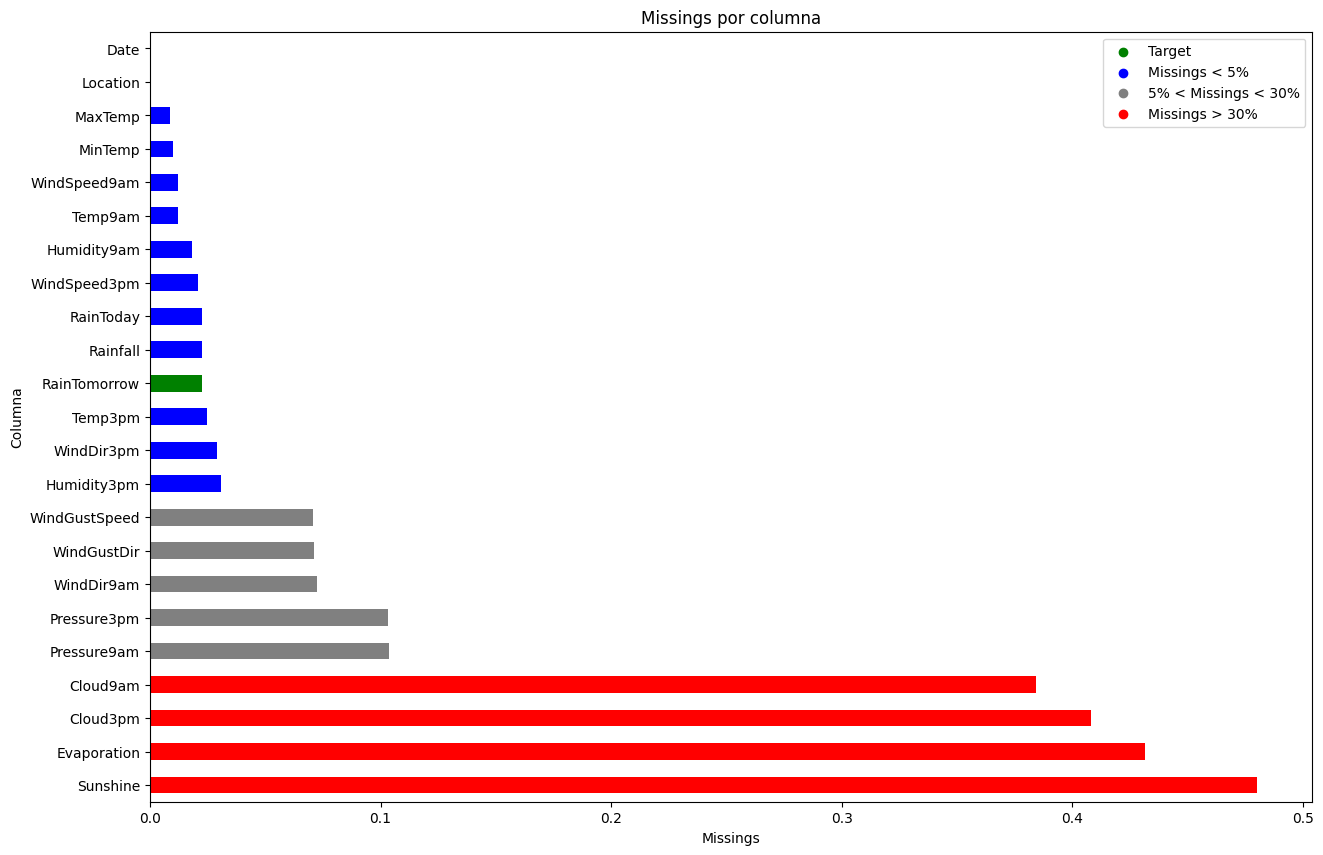

In [12]:
# Grafiquemos..

target = 'RainTomorrow'

# Defino primero una barra de color
colors = ['green' if col == target 
            else 'red' if df_null[col] > 0.30 
            else 'blue' if df_null[col] < 0.05 
            else 'gray' for col in df_null.index]

plt.figure(figsize=(15, 10))
df_null.plot(kind='barh', color=colors)
plt.xlabel('Missings')
plt.ylabel('Columna')
plt.title('Missings por columna')

# Crear la tabla de leyendas
legend_labels = ['Target', 'Missings < 5%', '5% < Missings < 30%', 'Missings > 30%']
legend_colors = ['green', 'blue', 'gray', 'red']

# Mostrar la tabla de leyendas
for color, label in zip(legend_colors, legend_labels):
    plt.scatter([], [], color=color, label=label)

plt.legend(loc='upper right')

In [13]:
# Veamos la variable *target*:
df_null[target]

0.02245978275814657

**OBSERVACIONES:**

- Salvo la fecha de la toma de datos `Date` como la localización `Location`, el resto de los *features* presenta *missings* en mayor o menor medida.

- Los atributos `Sunshine`, `Evaporation`, `Cloud3pm` y `Cloud9am` presentan entre un 30% y 50% de datos faltantes.

- El restos de los atributos tienen menos del 10% de datos faltantes.

- La variable *target* `RainTomorrow` presenta un 2.2% de datos faltantes.

- Se observan 2 tipos de variables: numéricas (data type: float64) y categóricas (data type: object).

- La columna `Date` necesita ser convertida a formato de pandas tipo "datetime".

In [14]:
# Convertimos el atributo `Date` a formato de fecha de pandas
# rain_df['Date'] = pd.to_datetime(rain_df['Date'])

In [15]:
# Veamos algo de información estadística
rain_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


**OBSERVACIONES:**

- Se observan varias columnas con *outliers*, por ejemplo, `Rainfall` presenta un valor máximo de 371 cuando el 75% de los datos son menores a 0.80.

#### 3.4 Análisis del target

In [16]:
rain_df['RainTomorrow'].nunique()

2

In [17]:
rain_df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [18]:
rain_df['RainTomorrow'].value_counts()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

In [19]:
rain_df['RainTomorrow'].value_counts()/ninstances

RainTomorrow
No     0.758394
Yes    0.219146
Name: count, dtype: float64

**OBSERVACIONES:**
- La variable objetivo es binaria y toma valores **Yes** o **No**.

- Se tiene un 75.8% de casos en donde no llueve (No) y un 21.9% donde (Yes). El porcentaje restante correponde al 2.2% de datos faltantes.

A las instancias del *target* donde se tiene *missings*, se las saca del dataset directamente, pues de otro modo, si aplicasemos algún método de imputación, estarías sesgando nuestros resultados.

In [20]:
rain_df.dropna(subset=['RainTomorrow'], inplace=True)

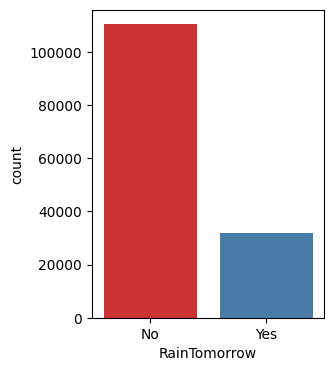

In [21]:
f, ax = plt.subplots(figsize=(3, 4))
ax = sns.countplot(x="RainTomorrow", data=rain_df, palette="Set1", hue="RainTomorrow")
plt.show()

#### 3.5 Correlación entre features

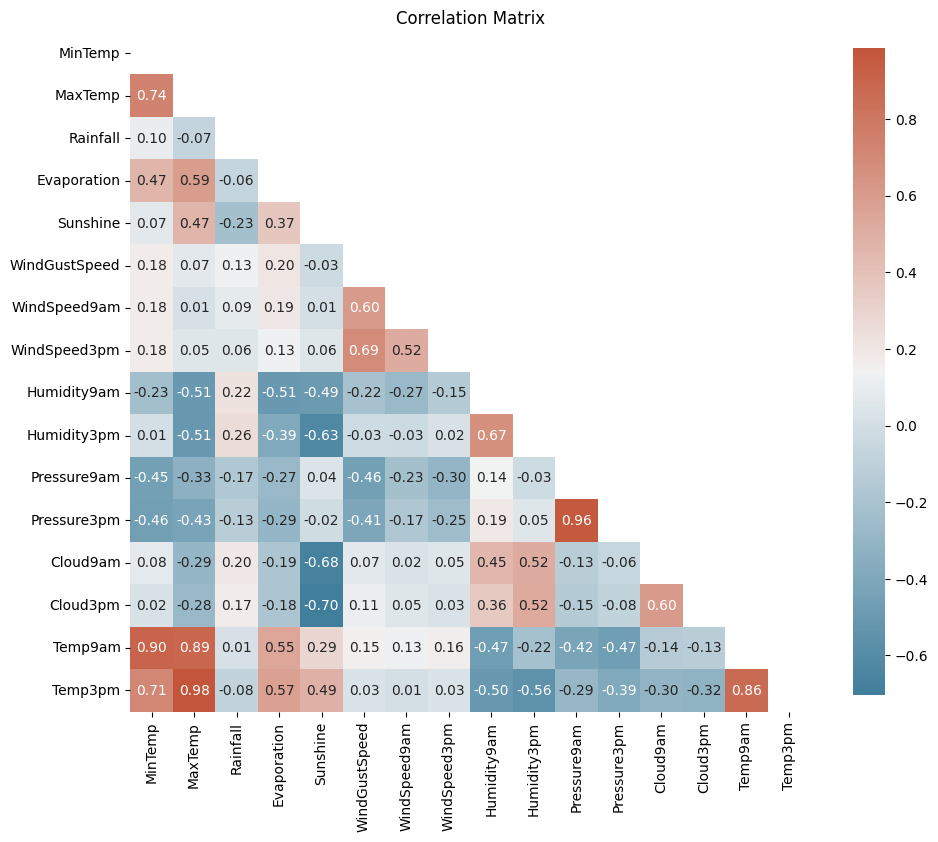

In [22]:
plt.figure(figsize=(10, 10))
plt.title('Correlation Matrix')

# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(rain_df.corr(numeric_only=True)))

# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Crear el mapa de calor
sns.heatmap(rain_df.corr(numeric_only=True), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap, cbar_kws={"shrink": .7})
plt.tight_layout()

**OBSERVACIONES:**
- Hay una fuerte correlación entre `Temp9am`y `Temp3am`, así como de estos 2 atributos con la `MinTemp`y `MaxTemp`.
- Hay una buena correlación entre `WindGustSpeed` y sus equivalentes a las 9AM y 3PM.
- En términos generales, hay una buena correlación entre los mismos pares de variables medidos por la mañana y por la tarde (p.ej., `Temp9am` y `Temp3pm`). 

**PREGUNTAS:**
- ¿Puedo quedarme solo con uno de esos pares?¿Con el que tenga menos missings?
- ¿En caso de missings, puedo usar uno para estimar el otro?

In [23]:
def get_corr_var(corr_matrix, threshold):
    corr_pairs = np.argwhere((corr_matrix < -threshold) | (corr_matrix > threshold))
    corr_columns = []
    
    for pair in corr_pairs:
        row, col = pair
        if row < col:
            found = False
            for corr_set in corr_columns:
                if corr_matrix.index[row] in corr_set or corr_matrix.columns[col] in corr_set:
                    corr_set.add(corr_matrix.index[row])
                    corr_set.add(corr_matrix.columns[col])
                    found = True
                    break
            if not found:
                corr_columns.append({corr_matrix.index[row], corr_matrix.columns[col]})
    
    return [list(corr_set) for corr_set in corr_columns]

# Llamada a la función para obtener pares de columnas correlacionadas por encima de cierto umbral
umbral = 0.85  # Establece tu umbral de correlación aquí
columnas_correlacionadas = get_corr_var(rain_df.corr(numeric_only=True), umbral)


print(f"Grupo de atributos con correlación mayor a {umbral}:",columnas_correlacionadas)
print(f"Cantidad de grupos de atributos con correlación mayor a {umbral}:",len(columnas_correlacionadas))

Grupo de atributos con correlación mayor a 0.85: [['MaxTemp', 'Temp3pm', 'Temp9am', 'MinTemp'], ['Pressure9am', 'Pressure3pm']]
Cantidad de grupos de atributos con correlación mayor a 0.85: 2


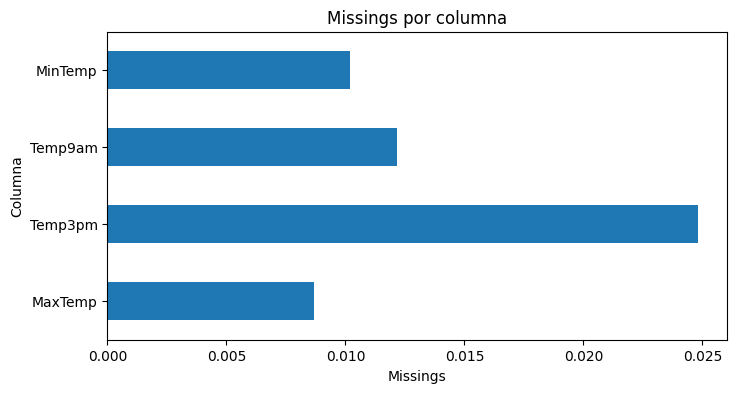

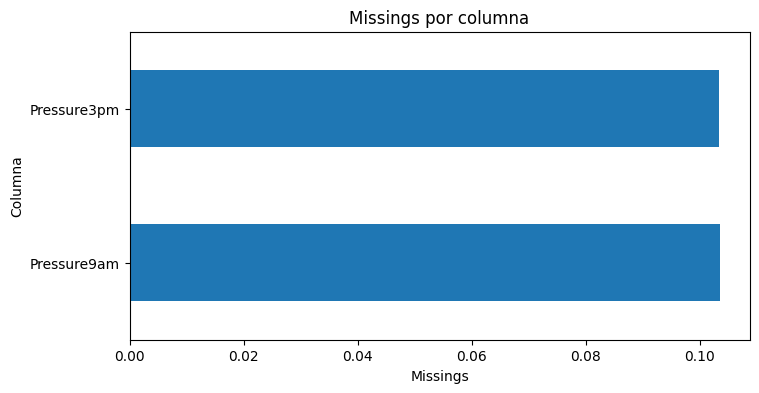

In [24]:
# Grafiquemos los missings para cada grupo...

for i in range(len(columnas_correlacionadas)):
    target = 'RainTomorrow'
    plt.figure(figsize=(8, 4))
    df_null[columnas_correlacionadas[i]].plot(kind='barh')
    plt.xlabel('Missings')
    plt.ylabel('Columna')
    plt.title('Missings por columna')

    plt.show()

**OBSERVACIONES:**
- En relación a la temperatura, se observa que los valores mínimos y máximos representan atributos más robustos que la temperatura a las 9AM y 3PM al tener menos *missings*. Podría obtarse por un modelo que solo retenga estos dos *features*.

- Respecto de la presión, vemos que ambos valores tienen una misma cantidad de missings. Posiblemente correspondan a la misma instancia (día) y se deba a algún problema con la toma de datos.

#### 3.6 Locaciones del dataset

In [25]:
# Cantidad de lugares diferentes donde se tomaron los datos
nloc = rain_df['Location'].nunique()
nloc

49

In [26]:

location_df = pd.DataFrame(rain_df['Location'].unique(),columns=['Location']).sort_values(by='Location')

def get_geocoord(place):
    'Función para obtener la latitud y longitud de un lugar "place" en Australia'
    
    country = 'Australia'
    # Divide las palabras (en caso de que sea necesario)
    place = re.sub(r'([a-z])([A-Z])', r'\1 \2', place)
    
    # Crear un objeto geolocalizador
    geolocator = Nominatim(user_agent="myGeocoder")
    
    location = f"{place}, {country}"
    location_info = geolocator.geocode(location)
    
    if location_info:
        return (location_info.latitude, location_info.longitude)
    else:
        return (None, None)

place_coords = {}
for location in location_df['Location']:
    place_coords[location] = get_geocoord(location)


### 4. TRAIN & TEST SET

In [27]:
X_full = rain_df.drop(columns=['RainTomorrow'])                 # Drop the target column from features
y_full = np.where(rain_df['RainTomorrow'] == "Yes", 1, 0)       # Target variable

# Split the dataset
rnd_seed = 42   # For reproducibility         
ftest = 0.20    # Fracción de datos para "train"

X_train, X_test, y_train, y_test = train_test_split(
                                                    X_full, y_full, 
                                                    test_size=ftest,        
                                                    stratify=y_full,       # Keep class proportions the same
                                                    random_state=rnd_seed         
                                                    )

print("Dimension de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimension de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimension de X_train: (113754, 22)
Valores de y_train: 113754
Dimension de X_test: (28439, 22)
Valores de y_test: 28439


### 5. DATA TRANSFORMATION

Se define el siguiente diagrama de trabajo para pre-procesamiento de datos:

1. Agrega nueva columna con la cantidad de nulos por instancia.

2. Extraer mes de la instancia: Permite evaluar las variables por estacionalidad.

3. Imputación jerárquica de *missings*:
    - Para variable numérica:
        - Si la variable es NaN, toma la media en ese mes en esa ciudad.
        - Si continua NaN, toma la media del mes en todas las ciudades.
        - Si continua NaN, toma la media del dataset.

    -   Para variables categóricas:
        - Idem a numéricas pero usando la moda en lugar de la media.

4. Convertir variable categórica `Location`a variables numéricas `Latitude` y `Longitude`.

5. Convertir variables categóricas de dirección cardinal de viento a numérica expresada en ºDEG. Por ej., N -> 0º, NE -> 45º, ...

6. Convertir variable numérica en ºDEG de dirección del viento a cos y sin. Por ej., NE -> 45º -> (0.707, 0.707) ...

7. Eliminar columnas categóricas reemplazadas por numéricas.

8. Eliminar columna numérica de dirección del viento en ºDEG.

9. Convertir variable binaria `RainToday` a numérica Yes/No -> 1, 0 y agregar variable binaria si 'RainToday' es nulo o no (1/0).

10. Escalar las variables entre 0 y 1.

In [28]:
# Define PIPELINE for data treatment flow
preproc_pipeline = Pipeline(steps = [
    ("null_count", CountNullsTransformer()),                                                                            # Agrega columna con el total de nulos por instancia
    ("date_expander", ExpandDateTransformer(year = False,)),                                                            # Extract month from date
    ("imputer", HierarchicalImputer()),                                                                                 # Missings imputation                                                                  
    ("coordinates", CoordinateTransformer2(place_coords)),                                                              # Convert "Location" into Latitude and Longitude
    ("wind_direction", WindDirectionTransformer()),                                                                     # Convert cardinal direction into degree
    ("wind_direction_deg", ExtendedWindDirectionTransformer()),                                                         # Convert degree into cos and sin
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm",])),                  # Drop categorical columns
    ("drop_directions_deg", DropColumnsTransformer(columns=["WindGustDirDeg", "WindDir9amDeg", "WindDir3pmDeg",])),     # Drop auxiliary columns
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),                                        # Drop categorical columns
    ("rain_today", RainTodayTransformer(NullCount = False)),                                                            # Convert binary variable
    ("minmax", MinMaxScaler()),                                                                                         # Scale features
])

preproc_pipeline

Pipeline(steps=[('null_count', CountNullsTransformer()),
                ('date_expander', ExpandDateTransformer(year=False)),
                ('imputer', HierarchicalImputer()),
                ('coordinates',
                 CoordinateTransformer2(city_coords={'Adelaide': (-34.9281805,
                                                                  138.5999312),
                                                     'Albany': (-35.0247822,
                                                                117.883608),
                                                     'Albury': (-36.0737734,
                                                                146.9135265),
                                                     'AliceSprings': (-23.6983884,
                                                                      133.8812885),
                                                     'BadgerysCr...
                ('drop_directions',
                 DropColumnsTransformer(columns=['WindGustDir', 'WindDir9am',
                                                 'WindDir3pm'])),
                ('drop_directions_deg',
                 DropColumnsTransformer(columns=['WindGustDirDeg',
                                                 'WindDir9amDeg',
                                                 'WindDir3pmDeg'])),
                ('drop_date_location',
                 DropColumnsTransformer(columns=['Date', 'Location'])),
                ('rain_today', RainTodayTransformer(NullCount=False)),
                ('minmax', MinMaxScaler())])

In [29]:
X_train_transformed = preproc_pipeline.fit_transform(X_train)

In [30]:
# Generate subsampling for hyperparameter tunning
sample_frac = 0.10

(X_train_transformed_sampled, y_train_sampled) = sample_array(X_train_transformed, y_train.reshape(-1, 1), sample_frac)

In [31]:
# Transform test data based on training fit
X_test_transformed = preproc_pipeline.transform(X_test)

### 6. LOGISTIC REGRESSION

#### 6.1 Baseline Logistic Regression Model

In [32]:
from sklearn.linear_model import LogisticRegression

# Entrenamos el modelo por máxima verosimilitud
log_ria = LogisticRegression(random_state = 0, 
                            class_weight='balanced',    # Balanceamos por la diferencia de proporciones de clases
                            n_jobs=12)       
log_ria.fit(X_train_transformed, y_train)

/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', n_jobs=12, random_state=0)

#### 6.2 Feature selection using L1 Logistic Regresion

In [33]:
from sklearn.model_selection import cross_val_score

log_model = LogisticRegression(random_state = 0, 
                                class_weight='balanced',
                                n_jobs=12) 

log_model.fit(X_train_transformed_sampled, y_train_sampled)

nfeatures = X_train_transformed_sampled.shape[1]                # Cantidad de atributos

# Generamos varios valores de alpha para la búsqueda pedida
nalpha = 100
alphamin = 0.0
alphamax = 100
alpha_values = np.linspace(alphamin, alphamax, nalpha)

nfolds = 3      # Cantidad de validaciones cruzadas

# Inicializo arraglos para guardar coeficientes de Lasso
coeffs_lasso = np.zeros([nalpha, nfeatures])

# Inicializo arraglos para guardar f1-score promedio de cross-validation, para cada alpha
f1_lasso = np.zeros([nalpha])

# Guardamos los coeficientes de la regresión logistica (alpha = 0)
coeffs_lasso[0, :] = log_model.coef_.copy()

# Calculamos los coeficientes para diferentes valores de alpha
for index, alpha in enumerate(alpha_values):

    if index == 0:  
        f1_lr_cv = cross_val_score(log_model, 
                                    X_train_transformed_sampled, y=y_train_sampled, 
                                    scoring='f1', 
                                    cv=nfolds, 
                                    n_jobs=12)       # Obtenemos el set de accurary por Cross-validation para linear regression
        f1_lr = f1_lr_cv.mean()       # f1-score mean
        f1_lasso[0] = f1_lr            
        
        continue

    # Creamos los modelos
    logL1_model = LogisticRegression(random_state = 0, 
                                    class_weight='balanced',
                                    n_jobs=12,
                                    penalty='l1',
                                    C=1/alpha, 
                                    solver='liblinear')

    # Los entrenamos
    logL1_model.fit(X_train_transformed_sampled, y_train_sampled)

    # Obtenemos el set de ACC por cross-validation
    f1_lasso_cv  = cross_val_score(logL1_model, 
                                    X_train_transformed_sampled, y=y_train_sampled, 
                                    scoring='f1', 
                                    cv=nfolds, 
                                    n_jobs=12)

    # Obtenemos el f1-score medio
    f1_lasso[index] = f1_lasso_cv.mean()
    
    # Guardamos los coeficientes de las regresiones
    coeffs_lasso[index, :] = logL1_model.coef_.copy()

# Convertimos los resultados en un DataFrame para visualizarlos
Alpha_vs_MSE_df = pd.DataFrame({
    'Alpha': alpha_values,
    'f1_Lasso': f1_lasso, 
    })

/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs

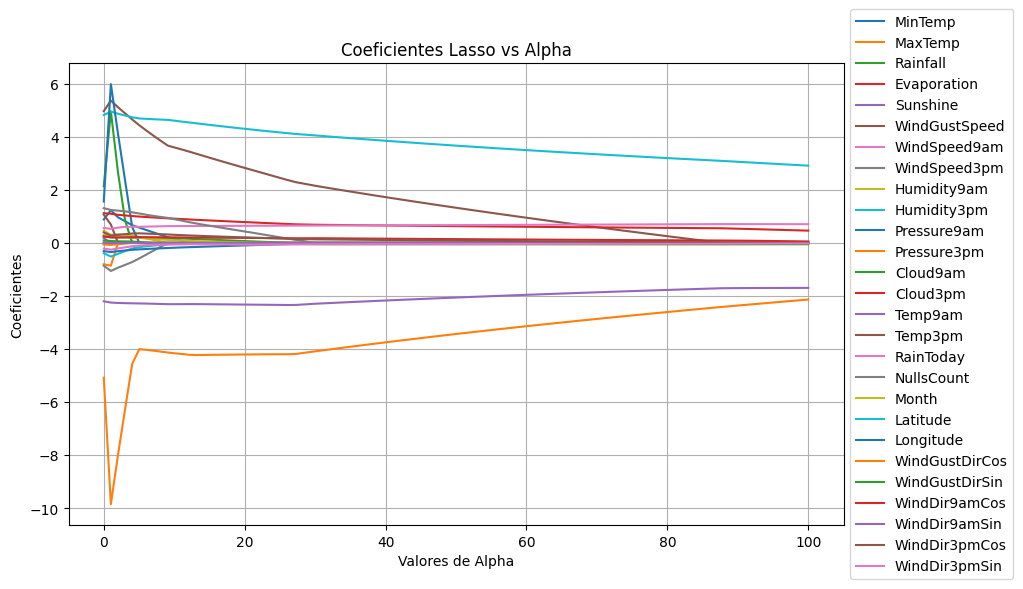

In [34]:
# Nombres de columnas del set de entrenamiento
column_names = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'NullsCount', 'Month', 'Latitude',
       'Longitude', 'WindGustDirCos', 'WindGustDirSin', 'WindDir9amCos',
       'WindDir9amSin', 'WindDir3pmCos', 'WindDir3pmSin']

# Crear la figura y los ejes para la gráfica
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Graficar los coeficientes
lines = []
for i in range(coeffs_lasso.shape[1]):
    line, = ax.plot(alpha_values, coeffs_lasso[:, i], label=column_names[i])
    lines.append(line)

# Configuraciones adicionales de la gráfica
ax.set_title('Coeficientes Lasso vs Alpha')
ax.set_xlabel('Valores de Alpha')
ax.set_ylabel('Coeficientes')
ax.grid(True)

# Ajustar la leyenda fuera del gráfico
ax.legend(handles=lines, labels=[line.get_label() for line in lines], loc='center left', bbox_to_anchor=(1, 0.5))

# Ordenar las etiquetas de la leyenda según el orden de aparición en el gráfico
handles, labels = ax.get_legend_handles_labels()
order = np.argsort([column_names.index(label) for label in labels])
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='center left', bbox_to_anchor=(1, 0.5))


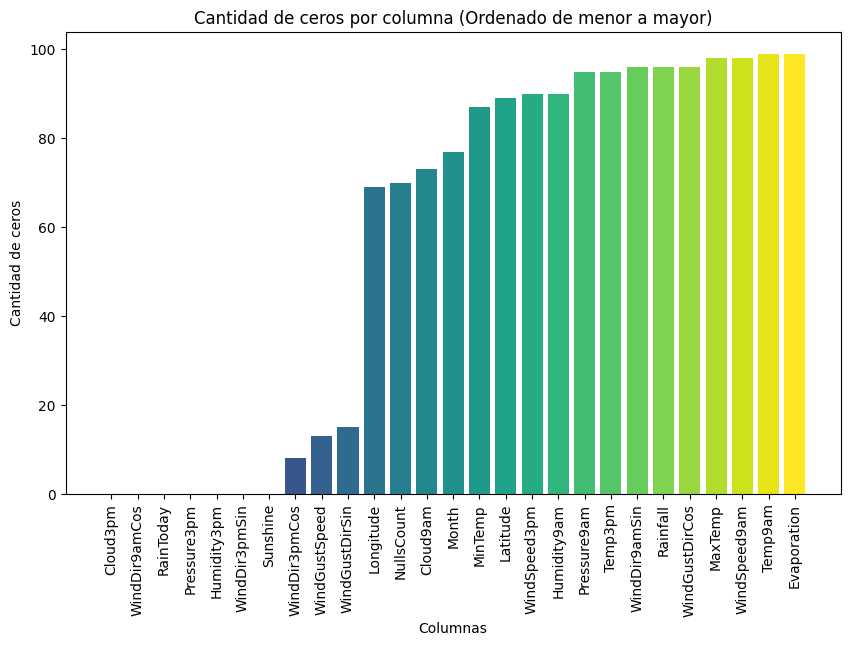

In [35]:
# Para ver la importancia de cada feature más claramente, cuento la cantidad de ceros y lo ordeno de menor cantidad (más importante) a mayor (menos importante)

# Contar la cantidad de ceros en cada columna
zeros_counts = np.sum(coeffs_lasso == 0, axis=0)

# Obtener los índices para ordenar los datos de menor a mayor
sorted_indices = np.argsort(zeros_counts)

# Ordenar los nombres de las columnas y los conteos de ceros
sorted_column_names = [column_names[i] for i in sorted_indices]
sorted_zeros_counts = zeros_counts[sorted_indices]

# Crear una lista de colores
colors = plt.cm.viridis(np.linspace(0, 1, len(zeros_counts)))

# Graficar los conteos de ceros por columna
plt.figure(figsize=(10, 6))
plt.bar(sorted_column_names, sorted_zeros_counts, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Columnas')
plt.ylabel('Cantidad de ceros')
plt.title('Cantidad de ceros por columna (Ordenado de menor a mayor)')
plt.show()

**OBSERVACIONES**

- Los *features* más importantes resultan:  `Cloud3pm`, `WindDir9amCos`, `WindGustDirSin`, `Sunshine`, `Humidity3pm`, `Pressure3pm`, `WindDir3pmCos` y `Raintoday`.   

### 7. SUPPORT VECTOR MACHINE MODEL

#### 7.1 Hyperparameters tunning: Grid Search

In [36]:
from sklearn.svm import SVC

svm_ria = SVC()

svm_grid = GridSearchCV(svm_ria,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "gamma": [0.1, 0.5, 1, 2, 10, 100], "kernel": ["rbf"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=False,
                    cv=5,
                    scoring='f1',
                    verbose = 1,
                    n_jobs=12)

svm_grid.fit(X_train_transformed_sampled, y_train_sampled)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=12,
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'gamma': [0.1, 0.5, 1, 2, 10, 100],
                          'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']}],
             refit=False, scoring='f1', verbose=1)

In [37]:
# Guardamos los mejores parámetros
svm_best_params = svm_grid.best_params_
svm_best_params 

{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}

#### 7.2 Best SVM model

In [38]:
# Definimos el mejor modelo
svm_ria_best = SVC(**svm_best_params)

# Entrenamos para todo el set de entrenamiento
svm_ria_best.fit(X_train_transformed, y_train)

SVC(C=10, gamma=0.5)

### 8. BOOSTING

#### 8.1 CATBOOST

In [39]:
from catboost import CatBoostClassifier

rnd_seed = 42   # For reproducibility    

# Inicializamos CatBoost con sus hiperparámetros por defecto
catboost_classifier = CatBoostClassifier(random_state=rnd_seed, verbose=0)

# Entrenamos el modelo
catboost_classifier.fit(X_train_transformed, y_train)

#### 8.2 XGBOOST

##### 8.2.1 Hyperparameter tunning: Randomized Search

In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Definir el modelo XGBoost
xgb_model = XGBClassifier(objective='binary:logistic', random_state=rnd_seed)

# Definir los rangos de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Configurar RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb_model,
                                param_distributions=param_dist,
                                n_iter=10,  # Número de combinaciones a probar
                                cv=5,
                                scoring='f1',
                                verbose=1,
                                n_jobs=12,
                                random_state=rnd_seed)

# Ajustar el modelo con los datos de entrenamiento
xgb_random.fit(X_train_transformed_sampled, y_train_sampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=12,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.1, 0.5],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [41]:
# Guardamos los mejores parámetros
xgb_best_params = xgb_random.best_params_
xgb_best_params

{'subsample': 0.8,
 'n_estimators': 200,
 'max_depth': 4,
 'learning_rate': 0.5,
 'gamma': 1,
 'colsample_bytree': 1.0}

##### 8.2.2 Best XGBoosting

In [42]:
# Inicializamos XGBoost con los mejores hiperparámetros de la grid search
xgb_classifier = XGBClassifier(
    **xgb_best_params,
    objective='binary:logistic',  # Usamos clasificación binaria
    random_state=rnd_seed,
    n_jobs=12, 
)

# Entrenamos el modelo
xgb_classifier.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=12,
              num_parallel_tree=None, random_state=42, ...)

#### 8.2.3 Feature importance

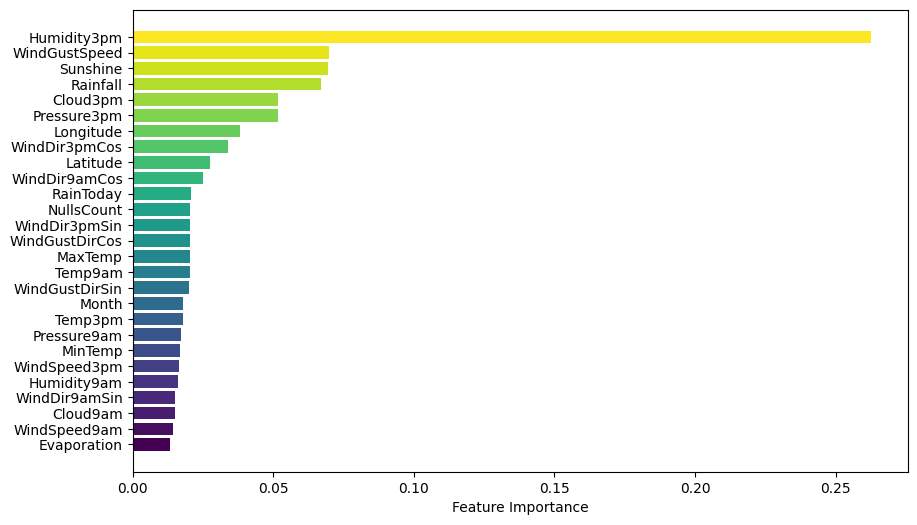

In [43]:
# Obtenemos la importancia de características
xgb_feature_importances = xgb_classifier.feature_importances_

# Ordenamos los índices
sorted_idx = xgb_feature_importances.argsort()

# Crear una lista de colores
colors = plt.cm.viridis(np.linspace(0, 1, len(xgb_feature_importances)))

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), xgb_feature_importances[sorted_idx], align='center', color=colors)
plt.yticks(range(len(sorted_idx)), [column_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

**OBSERVACIONES**

- Los 5 *features* más importantes resultan:  `Humidity3pm`, `WindGustSpeed`, `Rainfall`, `Sunshine` y `Cloud3pm`.

- Se observa que la mayoría coincide con lo encontrado con la regresión logistica L1.

### 9. RANDOM FOREST

#### 9.1 Hyperparameter tunning. Bayesian search

In [44]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# # Definir el modelo RandomForestClassifier
rf_model = RandomForestClassifier(random_state=rnd_seed)

# Definir los espacios de búsqueda para los hiperparámetros
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 5),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4),
    'max_features': Categorical([1, 'sqrt']),
    'bootstrap': Categorical([True, False])
}

# Configurar BayesSearchCV
rf_bayes = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    n_iter=50,  # Número de evaluaciones
    cv=5,
    scoring='f1',
    n_jobs=12,
    verbose=1,
    random_state=rnd_seed
)

# Ajustar el modelo con los datos de entrenamiento
rf_bayes.fit(X_train_transformed_sampled, y_train_sampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              n_jobs=12, random_state=42, scoring='f1',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': Integer(low=3, high=5, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=(1, 'sqrt'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=4, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize')},
              verbose=1)

In [45]:
# Guardamos los mejores parámetros
rf_best_params = rf_bayes.best_params_
rf_best_params

OrderedDict([('bootstrap', True),
             ('max_depth', 5),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 7),
             ('n_estimators', 91)])

#### 9.1 Best Random Forest Model

In [46]:
# Inicializamos modelo con los mejores hiperparámetros de la grid search
rf_classifier = RandomForestClassifier(**rf_best_params,
                                       random_state=rnd_seed,
                                       n_jobs=12)

# Entrenamos el modelo
rf_classifier.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=7,
                       n_estimators=91, n_jobs=12, random_state=42)

### 10. BAGGING

#### 10.1 Hyperparameter tunning: Optuna

In [47]:
from sklearn.ensemble import BaggingClassifier
import optuna
# Definir la función objetivo para la optimización de hiperparámetros
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_samples = trial.suggest_uniform('max_samples', 0.5, 1.0)
    max_features = trial.suggest_uniform('max_features', 0.5, 1.0)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    bootstrap_features = trial.suggest_categorical('bootstrap_features', [True, False])

    rf_classifier = RandomForestClassifier(random_state=rnd_seed)

    bagging_model = BaggingClassifier(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        bootstrap=bootstrap,
        bootstrap_features=bootstrap_features,
        random_state=rnd_seed
    )

    score = cross_val_score(bagging_model, X_train_transformed_sampled, y_train_sampled, scoring='f1', cv=5, n_jobs=12).mean()
    return score

# Realizar la optimización con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params

[I 2024-12-15 09:34:30,499] A new study created in memory with name: no-name-8bf0dba1-35c0-4c96-907d-9e1a2a7ee456
[I 2024-12-15 09:34:32,109] Trial 0 finished with value: 0.5413600046767233 and parameters: {'n_estimators': 27, 'max_samples': 0.9258993125711911, 'max_features': 0.5935867910097277, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 0 with value: 0.5413600046767233.
[I 2024-12-15 09:34:36,171] Trial 1 finished with value: 0.5773277804611254 and parameters: {'n_estimators': 74, 'max_samples': 0.9095112049045748, 'max_features': 0.8921939333456916, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 1 with value: 0.5773277804611254.
[I 2024-12-15 09:34:39,155] Trial 2 finished with value: 0.5590998663482456 and parameters: {'n_estimators': 78, 'max_samples': 0.6741335989730187, 'max_features': 0.5439621974674309, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 1 with value: 0.5773277804611254.
[I 2024-12-15 09:34:42,723] Trial 3 finishe

In [48]:
# Guardamos los mejores parámetros
bag_best_params = study.best_params
bag_best_params

{'n_estimators': 87,
 'max_samples': 0.5833029155904563,
 'max_features': 0.9870702877617732,
 'bootstrap': True,
 'bootstrap_features': False}

#### 10.2 Best Baggin Model

In [49]:
# Inicializamos modelo con los mejores hiperparámetros de la grid search
bagging_model = BaggingClassifier(**bag_best_params,
                                    random_state=rnd_seed,
                                    n_jobs=12)

# Entrenamos el modelo
bagging_model.fit(X_train_transformed, y_train)


BaggingClassifier(max_features=0.9870702877617732,
                  max_samples=0.5833029155904563, n_estimators=87, n_jobs=12,
                  random_state=42)

### 11. MÉTRICAS DE PERFORMANCE

#### 11.1 PREDICCIÓN SOBRE TEST SET

In [50]:
# Predecimos sobre el set de testeo para cada modelo
y_pred_log = log_ria.predict(X_test_transformed)                    # Base Logistic model
y_pred_svm = svm_ria_best.predict(X_test_transformed)               # Best SVM model
y_pred_catboost = catboost_classifier.predict(X_test_transformed)   # CatBoost Classifier
y_pred_xgb = xgb_classifier.predict(X_test_transformed)             # XGBoost Classifier
y_pred_rf = rf_classifier.predict(X_test_transformed)               # Random Forest model
y_pred_bag = bagging_model.predict(X_test_transformed)              # Bagging model

#### 11.2 CONFUSION

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Veamos la matriz de confusión para cada modelo
cm_log = confusion_matrix(y_test, y_pred_log, labels=log_ria.classes_)                              # Base Logistic model
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_ria_best.classes_)                         # Best SVM model
cm_catboost = confusion_matrix(y_test, y_pred_catboost, labels=catboost_classifier.classes_)        # CatBoost model
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=xgb_classifier.classes_)                       # XGBoost model
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_classifier.classes_)                          # Random Forest model
cm_bag = confusion_matrix(y_test, y_pred_bag, labels=bagging_model.classes_)                        # Bagging model

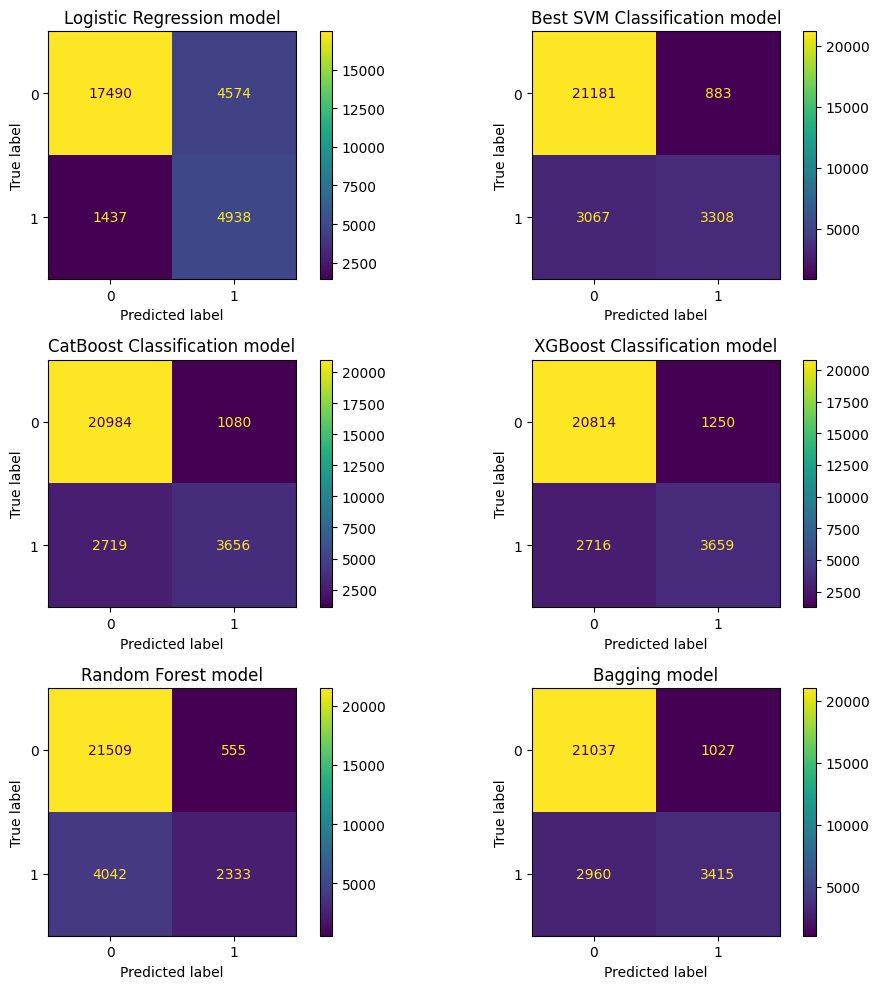

In [52]:
# Crear una figura con subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# ----------------------------------------------------------------
# Logistic Regression
# ----------------------------------------------------------------

disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_ria.classes_)
disp.plot(ax=axs[0, 0])
axs[0, 0].set_title("Logistic Regression model")
axs[0, 0].grid(False)

# # ----------------------------------------------------------------
# # Best SVM Model
# # ----------------------------------------------------------------

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_ria_best.classes_)
disp.plot(ax=axs[0, 1])
axs[0, 1].set_title("Best SVM Classification model")
axs[0, 1].grid(False)

# # ----------------------------------------------------------------
# # CatBoost Model
# # ----------------------------------------------------------------

disp = ConfusionMatrixDisplay(confusion_matrix=cm_catboost, display_labels=catboost_classifier.classes_)
disp.plot(ax=axs[1, 0])
axs[1, 0].set_title("CatBoost Classification model")
axs[1, 0].grid(False)

# # ----------------------------------------------------------------
# # Best XGBoost Model
# # ----------------------------------------------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_classifier.classes_)
disp.plot(ax=axs[1, 1])
axs[1, 1].set_title("XGBoost Classification model")
axs[1, 1].grid(False)

# # ----------------------------------------------------------------
# # Best Random Forest Model
# # ----------------------------------------------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_classifier.classes_)
disp.plot(ax=axs[2, 0])
axs[2, 0].set_title("Random Forest model")
axs[2, 0].grid(False)

# # ----------------------------------------------------------------
# # Best Bagging Model
# # ----------------------------------------------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bag, display_labels=bagging_model.classes_)
disp.plot(ax=axs[2, 1])
axs[2, 1].set_title("Bagging model")
axs[2, 1].grid(False)

plt.tight_layout()
plt.show()

### Observaciones 

- La regresion logistica tiene la mayor cantidad de verdaderos positivos pero una percision baja ya que tiene igual cantidad de falsos positivos. Se puede interpretar que cuando el modelo predice que va a llover hay, aproximadamente, un 50% de chances de que no llueva.

- En el caso de SVM tiene una precision mucho mejor que la regresion logistica pero tiene una baja recuperacion ya que, si una clase era positiva, hay, aproximadamente, 50% de chances de que lo clasifique como positivo.

- Para los modelos de boostrapping (CatBoost y XGBoost) se nota un buen balance entre precision y recuperacion. En comparacion con SVM presenta mejor recuperasion a costa de una disminucion de la precision y, comparado con la regresion logistica, ocurre lo contrario.

- En el caso de los modelos de ensamble: Random Forest tiene un muy mal comporamiento ya que presenta la peor recuperacion  y una precision similar a SVM. Asi mismo Bagging se comporta de manera muy parecida a SVM.

- En terminos generales todos presentan una buena precision de la clase negativa lo cual es esperable por el desbalance de las clases.


  

#### 11.3 EVALUACIÓN DE MÉTRICAS

In [101]:
# Veamos algunas métricas
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
raw_data = []
# ----------------------------------------------------------------
# Logistic Regression
# ----------------------------------------------------------------

print("Logistic Regression model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log)
recall = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)
raw_data.append([accuracy, f1, precision, recall, TP/P, TN/N])
             
print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print("\n")

P = np.sum(cm_log[1, :])
N = np.sum(cm_log[0, :])
TP = cm_log[1, 1]
TN = cm_log[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")

# # ----------------------------------------------------------------
# # Best SVM Model
# # ----------------------------------------------------------------

print("Best SVM model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
raw_data.append([accuracy, f1, precision, recall, TP/P, TN/N])

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print("\n")

P = np.sum(cm_svm[1, :])
N = np.sum(cm_svm[0, :])
TP = cm_svm[1, 1]
TN = cm_svm[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")


# ----------------------------------------------------------------
# CatBoost Model
# ----------------------------------------------------------------

print("CatBoost model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_catboost)
precision = precision_score(y_test, y_pred_catboost)
recall = recall_score(y_test, y_pred_catboost)
f1 = f1_score(y_test, y_pred_catboost)
raw_data.append([accuracy, f1, precision, recall, TP/P, TN/N])

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print("\n")

P = np.sum(cm_catboost[1, :])
N = np.sum(cm_catboost[0, :])
TP = cm_catboost[1, 1]
TN = cm_catboost[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")


# ----------------------------------------------------------------
# XGBoost Model
# ----------------------------------------------------------------

print("XGBoost model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
raw_data.append([accuracy, f1, precision, recall, TP/P, TN/N])

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print("\n")

P = np.sum(cm_xgb[1, :])
N = np.sum(cm_xgb[0, :])
TP = cm_xgb[1, 1]
TN = cm_xgb[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")


# ----------------------------------------------------------------
# Random Forest Model
# ----------------------------------------------------------------

print("Random Forest model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
raw_data.append([accuracy, f1, precision, recall, TP/P, TN/N])

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print("\n")

P = np.sum(cm_rf[1, :])
N = np.sum(cm_rf[0, :])
TP = cm_rf[1, 1]
TN = cm_rf[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")


# ----------------------------------------------------------------
# Bagging Model
# ----------------------------------------------------------------

print("Bagging model")
print("\n")
accuracy = accuracy_score(y_test, y_pred_bag)
precision = precision_score(y_test, y_pred_bag)
recall = recall_score(y_test, y_pred_bag)
f1 = f1_score(y_test, y_pred_bag)
raw_data.append([accuracy, f1, precision, recall, TP/P, TN/N])

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")
print("\n")

P = np.sum(cm_bag[1, :])
N = np.sum(cm_bag[0, :])
TP = cm_bag[1, 1]
TN = cm_bag[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print("\n")

Logistic Regression model


La exactitud de clasificación es: 0.7886353247301241
F1-score de testeo fue: 0.6216403348649839
Precisión de testeo fue: 0.5191337258200168
Recall de testeo fue: 0.7745882352941177


Sensibilidad: 0.7745882352941177
Especificidad: 0.7926939811457578


Best SVM model


La exactitud de clasificación es: 0.8611062273638314
F1-score de testeo fue: 0.6261593791406398
Precisión de testeo fue: 0.7893104271057026
Recall de testeo fue: 0.5189019607843137


Sensibilidad: 0.5189019607843137
Especificidad: 0.959980058013053


CatBoost model


La exactitud de clasificación es: 0.8664158374063786
F1-score de testeo fue: 0.6580865808658086
Precisión de testeo fue: 0.7719594594594594
Recall de testeo fue: 0.5734901960784313


Sensibilidad: 0.5734901960784313
Especificidad: 0.9510514865844815


XGBoost model


La exactitud de clasificación es: 0.8605436196772038
F1-score de testeo fue: 0.6485288904643743
Precisión de testeo fue: 0.7453656549195355
Recall de testeo fue: 0.573

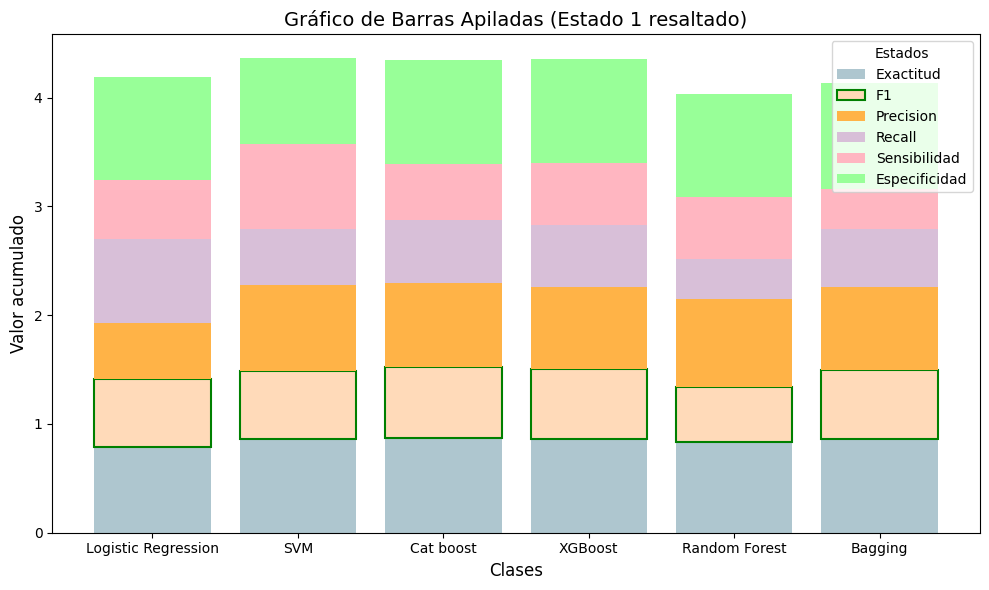

In [104]:
clases = ['Logistic Regression', 'SVM', 'Cat boost', 'XGBoost', 'Random Forest', 'Bagging']
estados = ['Exactitud', 'F1', 'Precision', 'Recall', 'Sensibilidad', 'Especificidad']

data = np.array(raw_data).T
colores = ['#AEC6CF', '#FFDAB9', '#FFB347', '#D8BFD8', '#FFB6C1', '#98FF98', '#FFFF99']   # Azul pastel, durazno, naranja pastel, lavanda

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(clases))

acumulado = np.zeros(len(clases))

max = data[0][1]
for i, estado in enumerate(estados):
    if data[i][1] > max:
        max = data[i][1]
        
for i, estado in enumerate(estados):
    edge = 'green' if i == 1 else 'none'
    if data[i][1] == max:
        edge = 'red'
        
    bars = ax.bar(
        x, 
        data[i], 
        bottom=acumulado, 
        label=estado, 
        color=colores[i],
        edgecolor='green' if i == 1 else 'none',  # Borde verde solo para Estado 1
        linewidth=1.5 if i == 1 else 0           # Grosor del borde
    )
    acumulado += data[i] 
ax.set_xlabel('Clases', fontsize=12)
ax.set_ylabel('Valor acumulado', fontsize=12)
ax.set_title('Gráfico de Barras Apiladas (Estado 1 resaltado)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(clases, fontsize=10)
ax.legend(title="Estados", fontsize=10)

plt.tight_layout()
plt.show()

Tomando la metrica de f1 como referencia vemos que los algoritmos de boosting son los que mejor performance tienen. Teniendo CatBoost una leve ventaja.

#### 11.4 CURVAS ROC

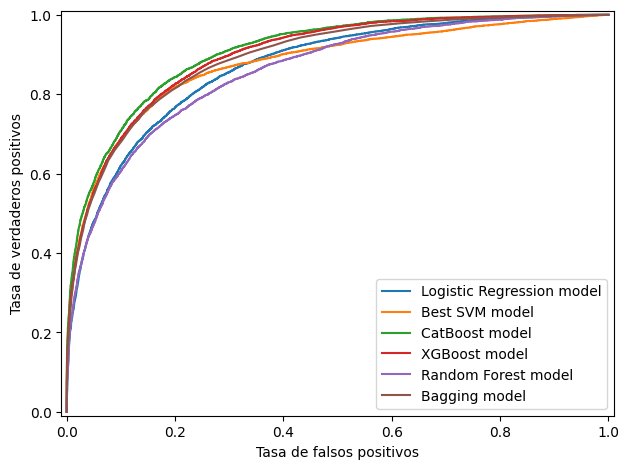

In [54]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

# Calculamos las curvas ROC

# ----------------------------------------------------------------
# Logistic Regression
# ----------------------------------------------------------------

prob_log = log_ria.predict_proba(X_test_transformed)[:, -1]             # Obtener las probabilidades
fpr_log, tpr_log, _ = roc_curve(y_test, prob_log)                       # Calcular la curva ROC

# ----------------------------------------------------------------
# Best SVM Model
# ----------------------------------------------------------------

decision_scores_svm = svm_ria_best.decision_function(X_test_transformed)        # Obtener las puntuaciones de decisión
fpr_svm, tpr_svm, _ = roc_curve(y_test, decision_scores_svm)                    # Calcular la curva ROC


# ----------------------------------------------------------------
# CatBoost Model
# ----------------------------------------------------------------


proba_catboost = catboost_classifier.predict_proba(X_test_transformed)[:, -1]           # Probabilidades de la clase positiva Catboost Classifier
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, proba_catboost)                       # Calcular la curva ROC

# ----------------------------------------------------------------
# XGBoost Model
# ----------------------------------------------------------------

proba_xgb = xgb_classifier.predict_proba(X_test_transformed)[:, -1]                 # Probabilidades de la clase positiva XGBoost Classifier
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, proba_xgb)                                  # Calcular la curva ROC


# ----------------------------------------------------------------
# Random Forest Model
# ----------------------------------------------------------------

proba_rf = rf_classifier.predict_proba(X_test_transformed)[:, -1]                # Probabilidades de la clase positiva Random Forest Classifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)                                  # Calcular la curva ROC

# ----------------------------------------------------------------
# Bagging Model
# ----------------------------------------------------------------

proba_bag = bagging_model.predict_proba(X_test_transformed)[:, -1]                    # Probabilidades de la clase positiva Bagging Classifier
fpr_bag, tpr_bag, _ = roc_curve(y_test, proba_bag)                                    # Calcular la curva ROC

# Gráficamos las curvas ROC

plt.plot(fpr_log, tpr_log, label="Logistic Regression model")
plt.plot(fpr_svm, tpr_svm, label="Best SVM model")
plt.plot(fpr_catboost, tpr_catboost, label="CatBoost model")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost model")
plt.plot(fpr_rf, tpr_rf, label="Random Forest model")
plt.plot(fpr_bag, tpr_bag, label="Bagging model")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

In [55]:
from sklearn.metrics import auc

# Calcular el área bajo la curva ROC (AUC)

auc_log = auc(fpr_log, tpr_log)
auc_svm = auc(fpr_svm, tpr_svm)
auc_catboost = auc(fpr_catboost, tpr_catboost)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_rf = auc(fpr_rf, tpr_rf)
auc_bag = auc(fpr_bag, tpr_bag)

print("AUC")
print("\n")
print(f"Logistic Regression Model AUC: {auc_log}")
print(f"Best SVM Model AUC: {auc_svm}")
print(f"CatBoost Model AUC: {auc_catboost}")
print(f"XGBoost Model AUC: {auc_xgb}")
print(f"Random Forest Model AUC: {auc_rf}")
print(f"Bagging Model AUC: {auc_bag}")

AUC


Logistic Regression Model AUC: 0.8680001421888551
Best SVM Model AUC: 0.8760743434429611
CatBoost Model AUC: 0.9068149696426794
XGBoost Model AUC: 0.8984738479148004
Random Forest Model AUC: 0.857126199718466
Bagging Model AUC: 0.8916020809338964


**OBSERVACIONES**

- En términos de área bajo la curva (AUC), ambos modelos de boosting performan mejor que el resto. En particular, CatBoost con los parámetros por defecto obtubo la mejor puntuación.